In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyod.utils.utility import standardizer
from sklearn.model_selection import train_test_split
from pyod.models.pca import PCA
from pyod.utils.utility import standardizer
from scipy.io import loadmat
from sklearn.metrics import balanced_accuracy_score
from pyod.models.kpca import KPCA
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.datasets import mnist

Ex 1

(500, 3)


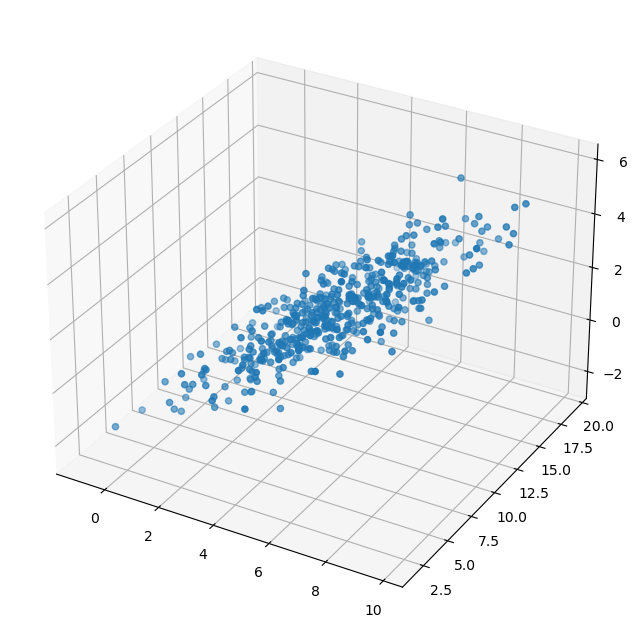

In [3]:
x = np.random.multivariate_normal([5, 10, 2], [[3, 2, 2], [2, 10, 1], [2, 1, 2]], 500)
print(x.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2])
plt.show()

In [4]:
x = x - np.mean(x, axis=0)
cov = np.cov(x.T)
eigenvalues, eigenvectors = np.linalg.eig(cov)

print(eigenvalues)
print(eigenvectors)


[11.34735788  3.87956755  0.38981102]
[[-0.3104661  -0.70762137 -0.63473049]
 [-0.93304766  0.35451705  0.06115325]
 [-0.18174943 -0.61121981  0.77030999]]


In [5]:
indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[indices]
print(eigenvalues)

[11.34735788  3.87956755  0.38981102]


In [6]:
variances = eigenvalues / np.sum(eigenvalues)
cumulative_variances = np.cumsum(variances)
print(cumulative_variances)

[0.72661519 0.97503889 1.        ]


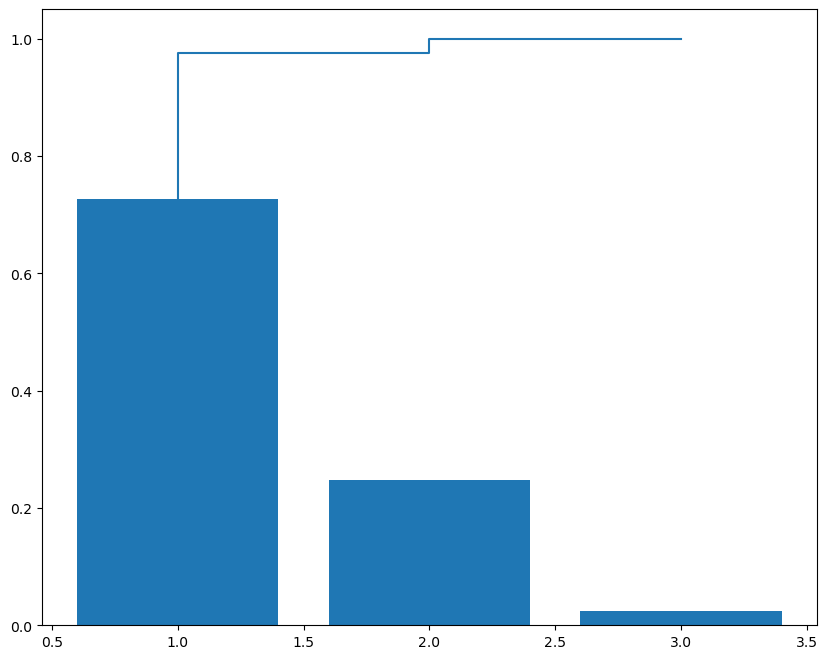

In [7]:
plt.figure(figsize=(10, 8))

components = np.arange(1, len(eigenvalues) + 1)
plt.bar(components, variances)

plt.step(components, cumulative_variances)

plt.show()


In [8]:
x_pca = np.dot(x, eigenvectors)
pc3_values = x_pca[:, 2] 
pc3_mean = np.mean(pc3_values)
 
pc3_threshold = np.quantile(np.abs(pc3_values - pc3_mean), 0.9)
pc3_outliers = np.abs(pc3_values - pc3_mean) > pc3_threshold

In [9]:
pc2_values = x_pca[:, 1] 
pc2_mean = np.mean(pc2_values)
 
pc2_threshold = np.quantile(np.abs(pc2_values - pc2_mean), 0.9)
pc2_outliers = np.abs(pc2_values - pc2_mean) > pc2_threshold

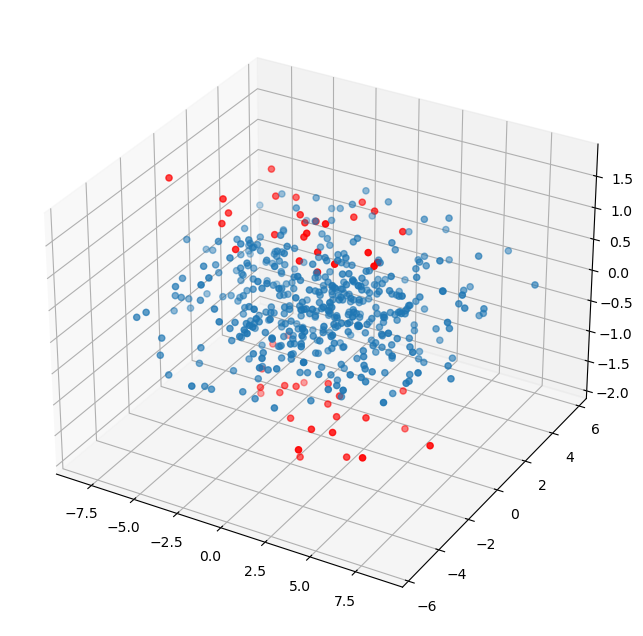

In [10]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_pca[~pc3_outliers, 0], x_pca[~pc3_outliers, 1], x_pca[~pc3_outliers, 2])
ax.scatter(x_pca[pc3_outliers, 0], x_pca[pc3_outliers, 1], x_pca[pc3_outliers, 2], c='red')

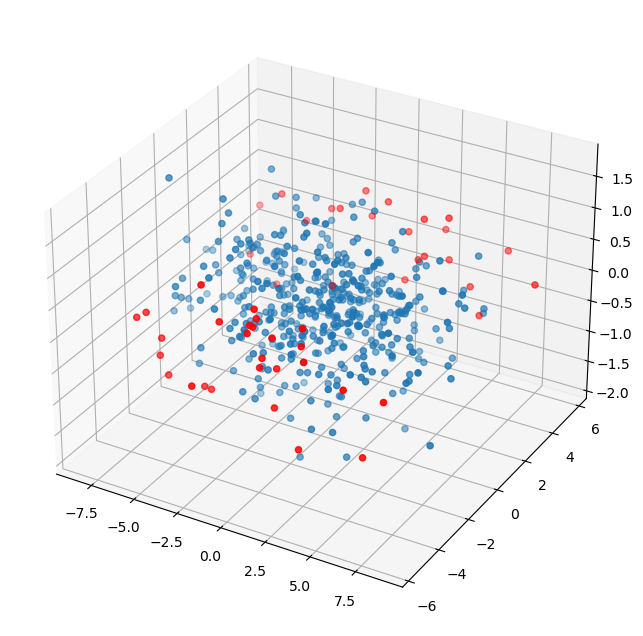

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_pca[~pc2_outliers, 0], x_pca[~pc2_outliers, 1], x_pca[~pc2_outliers, 2])
ax.scatter(x_pca[pc2_outliers, 0], x_pca[pc2_outliers, 1], x_pca[pc2_outliers, 2], c='red')

In [12]:
centroid = np.mean(x_pca, axis=0)

distances = np.sqrt(np.sum(((x_pca - centroid) / np.std(x_pca, axis=0)) ** 2, axis=1))

threshold = np.quantile(distances, 0.9)

outliers = distances > threshold

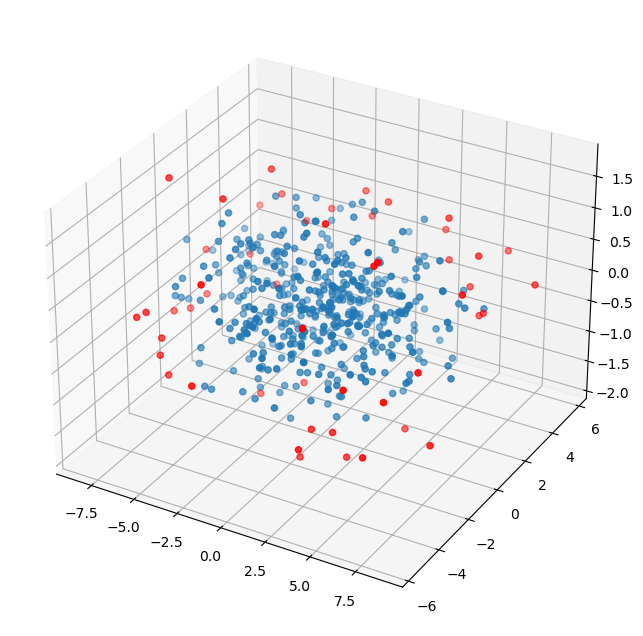

In [13]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_pca[~outliers, 0], x_pca[~outliers, 1], x_pca[~outliers, 2])
ax.scatter(x_pca[outliers, 0], x_pca[outliers, 1], x_pca[outliers, 2], c='red')

Ex 2

In [15]:
data = loadmat('shuttle.mat')
x = data['X']
y = data['y'].ravel() 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)
x_train, x_test = standardizer(x_train, x_test)

In [16]:
pca = PCA(contamination=0.1)  
pca.fit(x_train)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [17]:
variances = pca.explained_variance_
cumulative_variance = np.cumsum(variances)

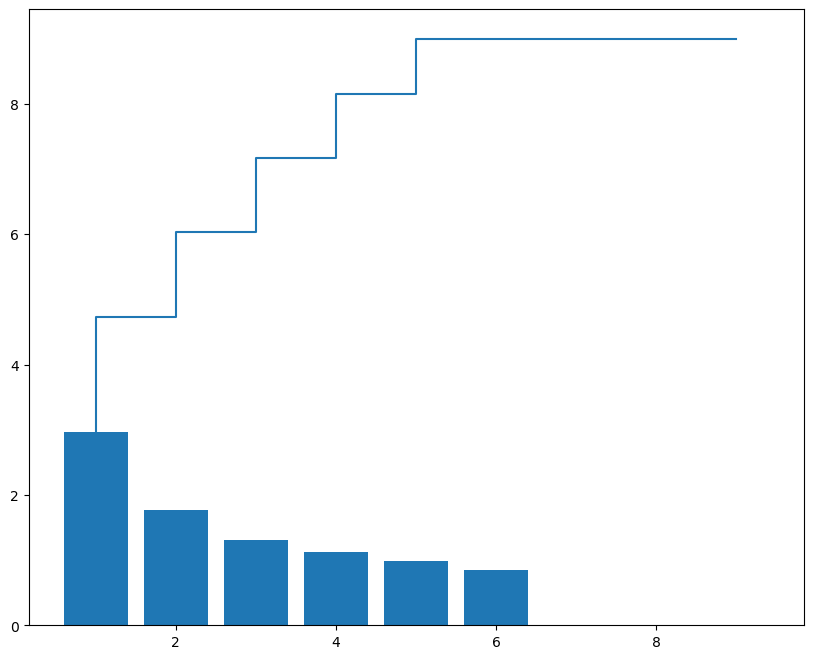

In [18]:
plt.figure(figsize=(10, 8))

plt.bar(range(1, len(variances) + 1), variances)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance)

plt.show()

In [19]:
train_pca_outliers = pca.labels_
test_pca_outliers = pca.predict(x_test)

train_BA = balanced_accuracy_score(y_train, train_pca_outliers)
test_BA = balanced_accuracy_score(y_test, test_pca_outliers)

print(train_BA, test_BA)

0.968329789189958 0.9602747621780607


In [20]:
kpca = KPCA(contamination=0.1) 
kpca.fit(x_train)

KPCA(alpha=1.0, coef0=1, contamination=0.1, copy_X=True, degree=3,
   eigen_solver='auto', gamma=None, kernel='rbf', kernel_params=None,
   max_iter=None, n_components=None, n_jobs=None,
   n_selected_components=None,
   random_state=RandomState(MT19937) at 0x1C054DD7840,
   remove_zero_eig=False, sampling=False, subset_size=20, tol=0)

In [21]:
train_kpca_outliers = kpca.labels_
test_kpca_outliers = kpca.predict(x_test)

train_BA = balanced_accuracy_score(y_train, train_kpca_outliers)
test_BAa = balanced_accuracy_score(y_test, test_kpca_outliers)

print(train_BA, test_BA)

0.6727473124061207 0.9602747621780607


Ex 3

In [23]:
x = data['X']
y = data['y'].ravel() 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [24]:
class Autoencoder(keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = keras.Sequential([
            layers.Dense(8, activation='relu', input_shape=(x_train.shape[1],)),
            layers.Dense(5, activation='relu'),
            layers.Dense(3, activation='relu')
        ])
        
        self.decoder = keras.Sequential([
            layers.Dense(5, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(9, activation='relu'),
            layers.Dense(x_train.shape[1], activation='sigmoid')
        ])
    
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()

In [25]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    x_train, x_train, 
    epochs=100, 
    batch_size=1024, 
    validation_data=(x_test, x_test)
)


Epoch 1/100

24/24 [==============================] - 1s 8ms/step - loss: 0.0186 - val_loss: 0.0172
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0158 - val_loss: 0.0138
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0117 - val_loss: 0.0092
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0053
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1

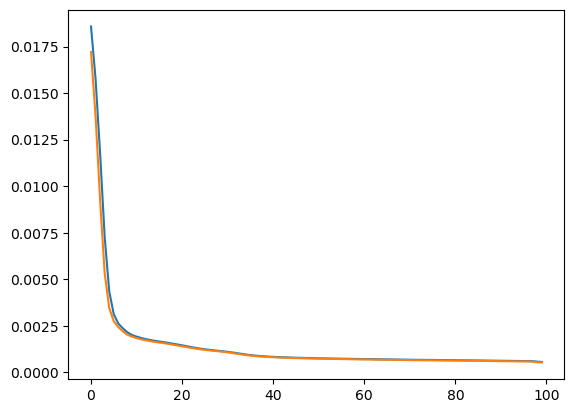

In [26]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.show()

In [27]:
train_reconstructed = autoencoder(x_train)
test_reconstructed = autoencoder(x_test)

train_error = np.mean((x_train - train_reconstructed)**2, axis=1)
test_error = np.mean((x_test - test_reconstructed)**2, axis=1)


In [28]:
threshold = np.quantile(train_error, 0.9)

train_pred = (train_error > threshold).astype(int)
test_pred = (test_error > threshold).astype(int)

train_BA = balanced_accuracy_score(y_train, train_pred)
test_BA = balanced_accuracy_score(y_test, test_pred)

print(train_BA, test_BA)

0.7635582388295123 0.7717942385882712


Ex 4

In [30]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [31]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_noisy = x_train + tf.random.normal(tf.shape(x_train), stddev=0.35)
x_test_noisy = x_test + tf.random.normal(tf.shape(x_test), stddev=0.35)

x_train_noisy = tf.clip_by_value(x_train_noisy, 0, 1)
x_test_noisy = tf.clip_by_value(x_test_noisy, 0, 1)

print(x_train.shape)

(60000, 28, 28)


In [32]:
class Autoencoder(keras.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = keras.Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', strides=2, padding='same', input_shape=(28, 28, 1)),
            layers.Conv2D(4, (3, 3), activation='relu', strides=2, padding='same')
        ])
        
        self.decoder = keras.Sequential([
            layers.Conv2DTranspose(4, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(8, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])
    
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()

In [33]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    x_train, x_train, 
    epochs=10, 
    batch_size=64, 
    validation_data=(x_test, x_test)
)

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0319 - val_loss: 0.0046
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 9/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0023

In [34]:
x_train = np.expand_dims(x_train, axis=-1)

train_reconstruction = autoencoder(x_train) 
train_reconstruction_error = tf.reduce_mean(tf.square(x_train - train_reconstruction), axis=(1, 2, 3)) 

threshold = tf.reduce_mean(train_reconstruction_error) + tf.math.reduce_std(train_reconstruction_error)

In [35]:
x_test = np.expand_dims(x_test, axis=-1)
x_test_noisy = np.expand_dims(x_test_noisy, axis=-1)

original_reconstruction = autoencoder(x_test)  
noisy_reconstruction = autoencoder(x_test_noisy)  

original_reconstruction_error = tf.reduce_mean(tf.square(x_test - original_reconstruction), axis=(1, 2, 3)) 
noisy_reconstruction_error = tf.reduce_mean(tf.square(x_test_noisy - noisy_reconstruction), axis=(1, 2, 3))  

original_test_labels = original_reconstruction_error > threshold  
noisy_test_labels = noisy_reconstruction_error > threshold  

original_accuracy = np.mean(~original_test_labels)  
noisy_accuracy = np.mean(~noisy_test_labels) 

print(original_accuracy, noisy_accuracy)

0.8793 0.0


In [36]:
original_images = x_test[:5]  
noisy_images = x_test_noisy[:5] 

original_reconstruction = autoencoder(original_images)
noisy_reconstruction = autoencoder(noisy_images)

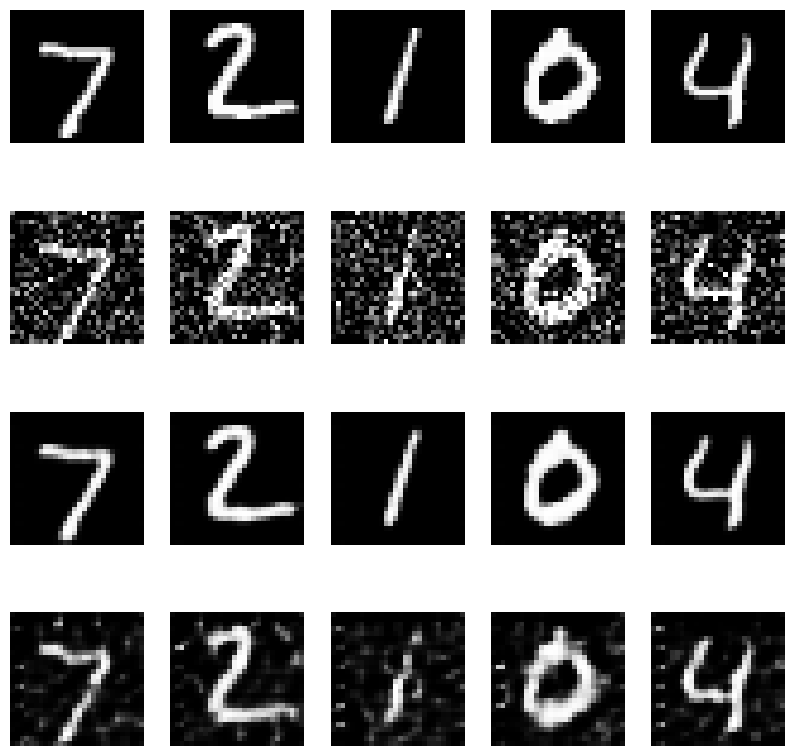

In [37]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))

for i in range(5):
    axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off') 

    axes[1, i].imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(original_reconstruction[i].numpy().reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')

    axes[3, i].imshow(noisy_reconstruction[i].numpy().reshape(28, 28), cmap='gray')
    axes[3, i].axis('off')

plt.show()

In [38]:
history = autoencoder.fit(
    x_train_noisy, x_train,  
    epochs=10, 
    batch_size=64,
    validation_data=(x_test_noisy, x_test) 
)

original_reconstruction = autoencoder(x_test)  
noisy_reconstruction = autoencoder(x_test_noisy) 


Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0098 - val_loss: 0.0093
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0094 - val_loss: 0.0091
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 8/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 9/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 10/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0089 - val_loss: 0.0087

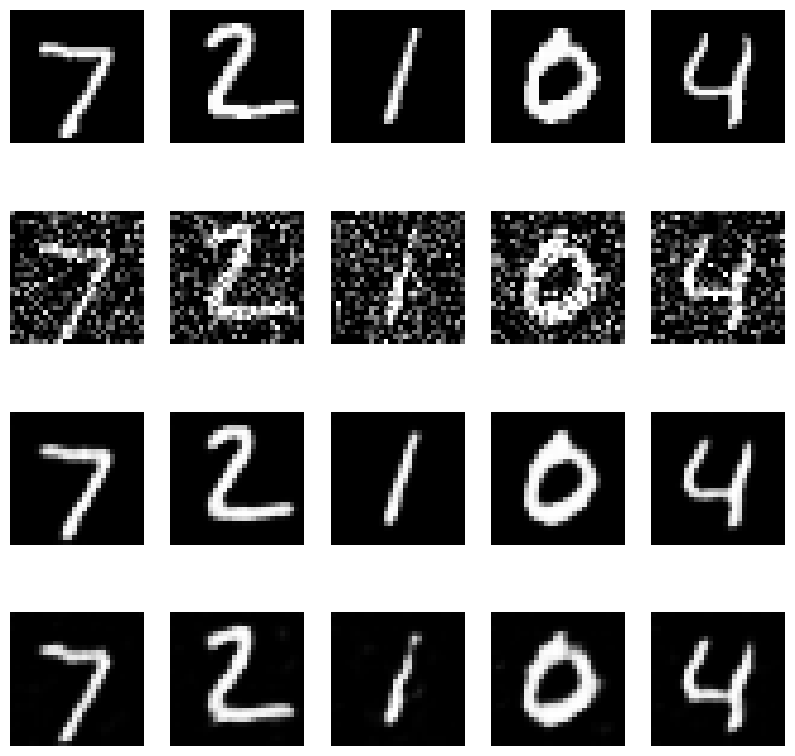

In [39]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))

for i in range(5):
    axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off') 

    axes[1, i].imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(original_reconstruction[i].numpy().reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')

    axes[3, i].imshow(noisy_reconstruction[i].numpy().reshape(28, 28), cmap='gray')
    axes[3, i].axis('off')

plt.show()